## Chassis Example Notebooks
Welcome to the examples section for [Chassis](https://chassis.ml), which contains notebooks that auto-containerize models built using the most common machine learning (ML) frameworks. 

#### What is Chassis?
Chassis allows you to automatically create a Docker container from your model code and push that container image to a Docker registry. All you need is your model loaded into memory and a few lines of Chassis code! Our example bank is here to provide reference examples for many common ML frameworks.  

Can't find the framework you are looking for or need help? Fork this repository and open a PR, or list the desired framework in a new issue. We're always interested in growing this example bank! 

The primary maintainers of Chassis also actively monitor our [Discord Server](https://discord.gg/cHpzY9yCcM), so feel free to join and ask any questions you might have. We'll be there to respond and help out promptly.

In [16]:
import cv2
import pickle
import tempfile
import chassisml
import numpy as np
import getpass
from shutil import rmtree
import json
import onnx
from onnx import backend
from onnx import numpy_helper
import onnxruntime as ort
import matplotlib.pyplot as plt

## Enter credentials
Dockerhub creds and Modzy API Key

In [ ]:
dockerhub_user = getpass.getpass('docker hub username')
dockerhub_pass = getpass.getpass('docker hub password')

## Load ONNX Model and Test Locally
This model was downloaded from the [ONNX Model Zoo](https://github.com/onnx/models/tree/master/vision/classification/mobilenet), which contains several pre-trained models saved in the ONNX open standard format.

In [3]:
# load model
model = onnx.load("models/mobilenetv2-7.onnx")

# check onnx file is valid model
onnx.checker.check_model(model)

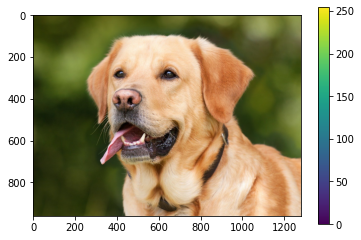

In [4]:
# format sample data and reshape
img = cv2.cvtColor(cv2.imread('data/dog.jpg'), cv2.COLOR_BGR2RGB)
img_show = cv2.resize(img, (224,224))

sample_img = np.reshape(img_show, (1,3,224,224)).astype(np.float32)

# load imagenet labels
labels = pickle.load(open('./data/imagenet_labels.pkl','rb'))

# visualize image
plt.figure()
plt.imshow(img)
plt.colorbar()
plt.grid(False)
plt.show()

In [5]:
# create onnx runtime inference session and print top prediction
session = ort.InferenceSession("models/mobilenetv2-7.onnx")
results = session.run(None, {"input": sample_img})
print("Top Prediction: {}".format(labels[results[0].argmax()]))

Top Prediction: sunglass


## Write process function

* Must take bytes as input
* Preprocess bytes, run inference, postprocess model output, return results

In [18]:
def process(input_bytes):
    # save model to filepath for inference
    tmp_dir = tempfile.mkdtemp()
    import onnx
    onnx.save(model, "{}/model.onnx".format(tmp_dir))
    
    # preprocess data
    decoded = cv2.cvtColor(cv2.imdecode(np.frombuffer(input_bytes, np.uint8), -1), cv2.COLOR_BGR2RGB)
    img = cv2.resize(decoded, (224,224))
    img = np.reshape(img, (1,3,224,224)).astype(np.float32)
    
    # run inference
    session = ort.InferenceSession("{}/model.onnx".format(tmp_dir))
    results = session.run(None, {"input": img})
    
    # postprocess
    inference_result = labels[results[0].argmax()]
    
    # format results
    structured_result = {
        "data": {
            "result": {"classPredictions": [{"class": str(inference_result)}]}
        }
    }
    
    # remove temp directory
    rmtree(tmp_dir)
    return structured_result

## Initialize Chassis Client
We'll use this to interact with the Chassis service

In [19]:
chassis_client = chassisml.ChassisClient("http://localhost:5000")

## Create and test Chassis model
* Requires `process_fn` defined above

In [ ]:
# create Chassis model
chassis_model = chassis_client.create_model(process_fn=process)

# test Chassis model locally (can pass filepath, bufferedreader, bytes, or text here):
sample_filepath = './data/dog.jpg'
results = chassis_model.test(sample_filepath)
print(results)

In [21]:
# test environment and model within Chassis service, must pass filepath here:

# dry run before build
test_env_result = chassis_model.test_env(sample_filepath)
print(test_env_result)

Starting test job... Ok!
{'model_output': 'Single input prediction:\n\nb\'{"data":{"result":{"classPredictions":[{"class":"sunglass"}]}}}\'\n'}


## Publish model to Docker
Need to provide model name, model version, and Dockerhub credentials

In [22]:
response = chassis_model.publish(
    model_name="ONNX MobileNet Image Classification",
    model_version="0.0.1",
    registry_user=dockerhub_user,
    registry_pass=dockerhub_pass,
)

job_id = response.get('job_id')
final_status = chassis_client.block_until_complete(job_id)

Starting build job... Ok!


In [23]:
if chassis_client.get_job_status(job_id)["result"] is not None:
    print("New model URL: {}".format(chassis_client.get_job_status(job_id)["result"]["container_url"]))
else:
    print("Chassis job failed \n\n {}".format(chassis_client.get_job_status(job_id)))

New model URL: https://integration.modzy.engineering/models/ehojcqknx4/0.0.1
